In [1]:
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
import numpy as np
from sklearn.metrics import auc

# Function to calculate the Excess Mass (EM) curve and Area Under the Curve (AUC)
def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])  # Initialize the EM_t array with zeros
    n_samples = s_X.shape[0]  # Get the number of samples in s_X
    s_X_unique = np.unique(s_X)  # Get the unique values from s_X
    EM_t[0] = 1.  # Set the first element of EM_t to 1

    for u in s_X_unique:
        # Update EM_t with the maximum value between the current EM_t and the new calculated value
        EM_t = np.maximum(
            EM_t,
            1. / n_samples * (s_X > u).sum() -
            t * (s_unif > u).sum() / n_generated * volume_support
        )

    # Find the index where EM_t is less than or equal to t_max
    amax = np.argmax(EM_t <= t_max) + 1

    # If amax is 1, it indicates t_max was not achieved
    if amax == 1:
        print('\n failed to achieve t_max \n')
        amax = -1

    # Calculate the AUC for the EM curve
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax

# Function to calculate the Mass Volume (MV) curve and Area Under the Curve (AUC)
def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]  # Get the number of samples in s_X
    s_X_argsort = np.argsort(s_X)  # Get the indices that would sort s_X
    mass = 0  # Initialize mass to zero
    cpt = 1  # Initialize counter to 1
    u = s_X[s_X_argsort[-1]]  # Get the maximum value from s_X
    mv = np.zeros(axis_alpha.shape[0])  # Initialize the mv array with zeros

    # Iterate through axis_alpha values
    for i in range(axis_alpha.shape[0]):
        while cpt <= n_samples:  # Ensure that cpt is within bounds
            u_index = -cpt
            if -cpt >= len(s_X_argsort):
                # Adjust index if out of bounds
                u_index = -len(s_X_argsort)

            u = s_X[s_X_argsort[u_index]]  # Get the value at the sorted index
            mass = 1. / n_samples * cpt  # Calculate mass

            if mass >= axis_alpha[i]:
                break  # Exit the loop if the required mass is reached

            cpt += 1

        # Calculate mv value
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support

    # Calculate the AUC for the MV curve
    return auc(axis_alpha, mv), mv

# Function for extending our data of values from previous timestamps (temporalization)
def temporalize(X, y, lookback):
    output_X = []  # Initialize list for temporalized input data
    output_y = []  # Initialize list for temporalized output data

    # Iterate through the data, creating temporal sequences
    for i in range(len(X) - lookback - 1):
        t = []  # Initialize list for a single temporal sequence
        for j in range(1, lookback + 1):
            # Gather past records up to the lookback period
            t.append(X[i + j - 1])
        output_X.append(t)  # Append the sequence to the output_X list
        output_y.append(y[i + lookback + 1])  # Append the corresponding y value to output_y

    # Convert lists to numpy arrays and return them
    return np.array(output_X), np.array(output_y)


In [3]:
# !pip install pyod

name=""
folder="A2Benchmark"
file_path = 'data/'+folder+'/'

method='using yahoo synthetic data by temporalize+percentile+CNN'

In [4]:
# !pip install pyod


data/A2Benchmark/synthetic_1.csv


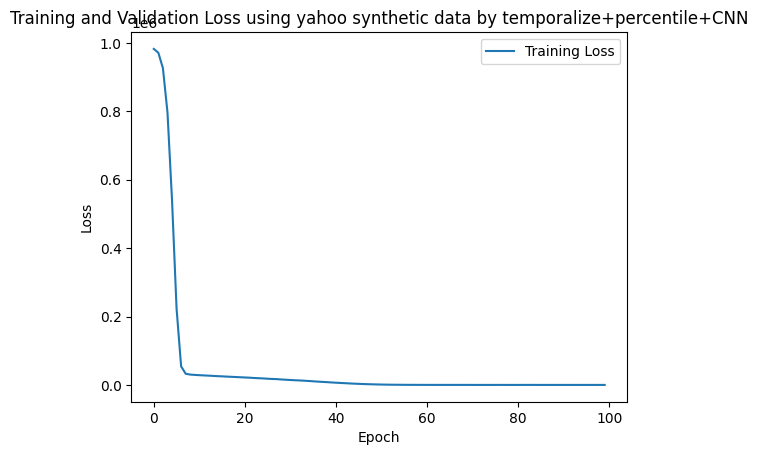

CNN - Area Under Excess-Mass (EM) Curve: 0.00035608446711087987
CNN - Area Under Mass-Volume (MV) Curve: 0.1405496806245564
CNN - Area Under Excess-Mass (EM) Curve: 0.5610687626152042
CNN - Area Under Mass-Volume (MV) Curve: 198.0345


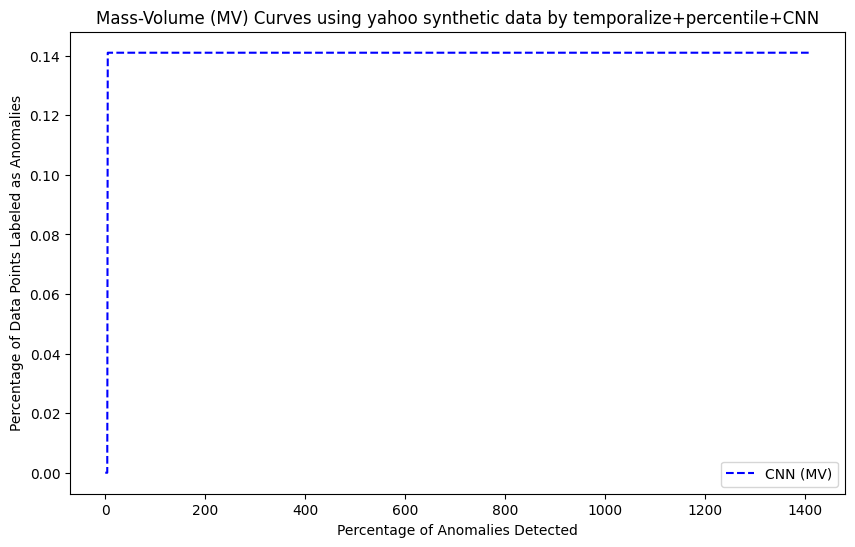

1421
1410


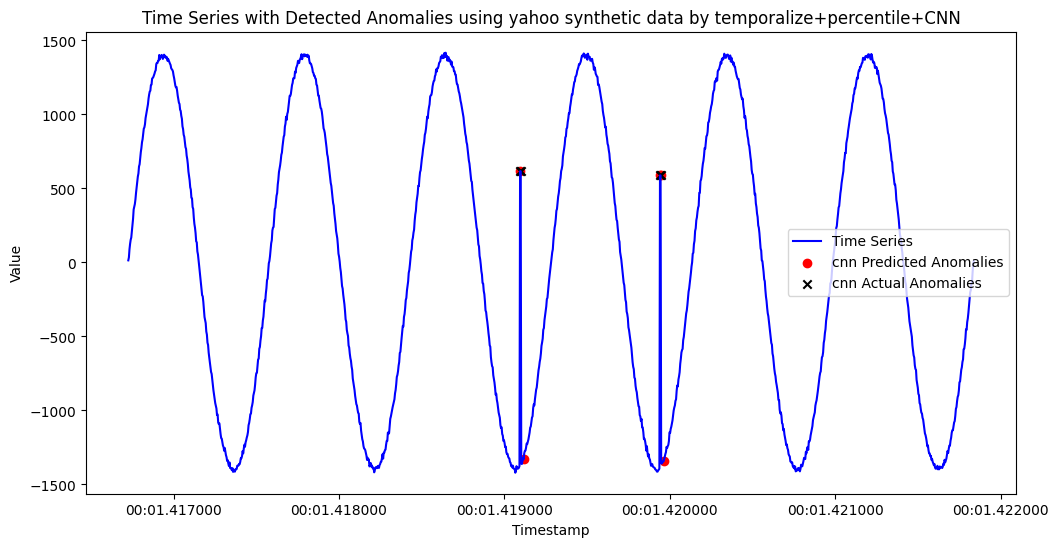

Actual Anomalies
                        timestamp       value  is_anomaly
658 1970-01-01 00:00:01.419094800  616.412915           1
659 1970-01-01 00:00:01.419098400  616.412915           1
893 1970-01-01 00:00:01.419940800  587.893627           1
894 1970-01-01 00:00:01.419944400  587.893627           1
Detected Anomalies
                        timestamp        value  anomaly_cnn
658 1970-01-01 00:00:01.419094800   616.412915            1
664 1970-01-01 00:00:01.419116400 -1330.229730            1
893 1970-01-01 00:00:01.419940800   587.893627            1
894 1970-01-01 00:00:01.419944400   587.893627            1
899 1970-01-01 00:00:01.419962400 -1343.969385            1
Precision: 0.6
Recall (Sensitivity): 0.75
F1-Score: 0.6666666666666665
Accuracy: 0.9978888106966924


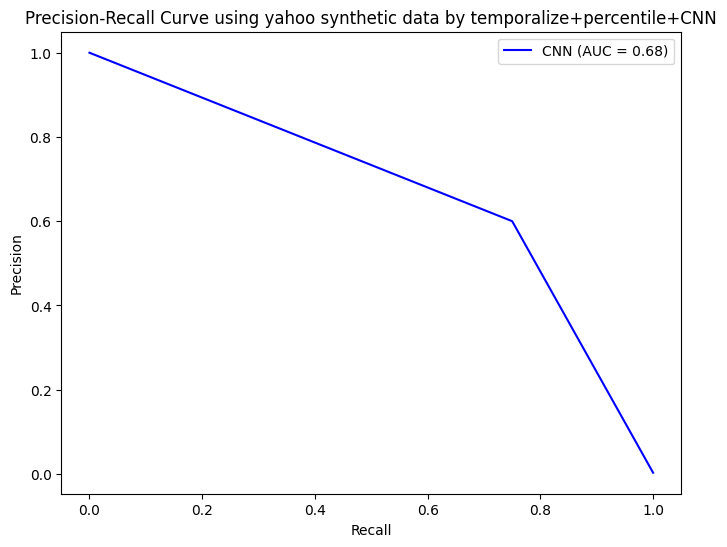

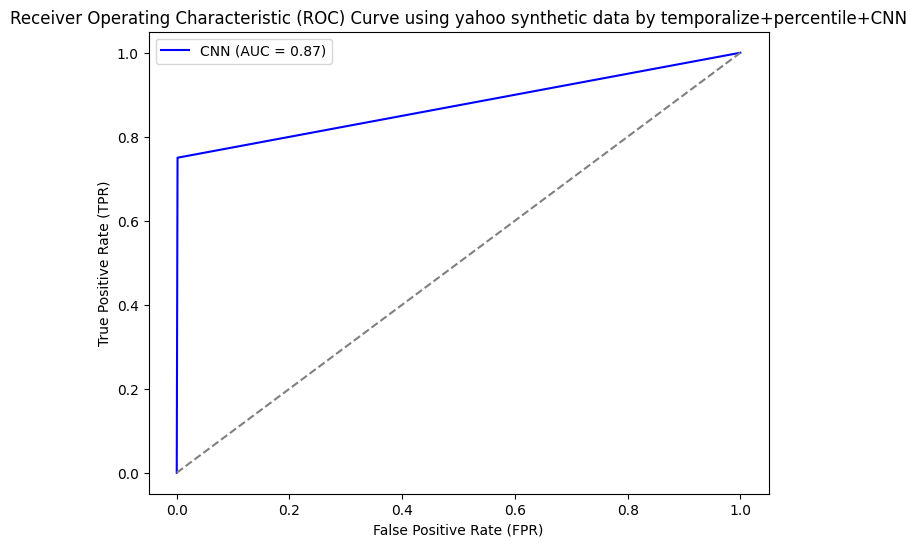

In [6]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from scipy.integrate import trapz
import matplotlib.pyplot as plt

import time
# Initialize a list to store evaluation metrics for each iteration
all_evaluation_metrics = []
for i in range(1,2):    #reading csv
    name = file_path+"synthetic_"+str(i)+'.csv'
#     name = file_path+"real_"+str(i)+'.csv'
    print(name)
    # Step 1: Prepare the data
    data_df = pd.read_csv(name, encoding="ISO-8859-1", header=0, usecols=["timestamp", "value", "is_anomaly"])
    data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])

    # Step 2: Split the data into training and testing sets
    # train_data, test_data = train_test_split(data_df, test_size=0.2, random_state=42)
    train_data=data_df
    test_data = data_df
    test_anomalies_lstm=test_data_df=test_data
    train_data = train_data[train_data['is_anomaly'] != 1]
    # Step 3: Convert time series data to sequences for training and testing sets
    sequence_length = 10

    def create_sequences(data):
        sequences = []
        for i in range(len(data) - sequence_length + 1):
            sequence = data[i:i + sequence_length]
            sequences.append(sequence)
        return np.array(sequences)

#     train_sequences = create_sequences(train_data['value'].values)
#     test_sequences = create_sequences(test_data['value'].values)
    train_sequences, train_labels = temporalize(train_data['value'].values, train_data['value'].values, sequence_length)
    test_sequences, test_labels = temporalize(test_data['value'].values, test_data['value'].values, sequence_length)

    # Step 4: Normalize the sequences
    scaler = StandardScaler()
    train_sequences = scaler.fit_transform(train_sequences)
    test_sequences = scaler.transform(test_sequences)

    start_time = time.time()
    # Step 5: Create and train the CNN model for time series forecasting
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output layer with linear activation for regression

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#     model.fit(train_sequences.reshape(-1, sequence_length, 1), train_data['value'].values[sequence_length + 1:], epochs=100, batch_size=64)

#     history = model.fit(train_sequences.reshape(-1, sequence_length, 1), train_data['value'].values[sequence_length - 1:],
#                         epochs=100, batch_size=64,verbose=0)
    
    history = model.fit(train_sequences, train_labels,
                        epochs=100, batch_size=64,verbose=0)
    # Calculate the training time
    training_time = time.time() - start_time
    # Step 6: Forecast on the test set using the CNN-LSTM model
    test_forecast = model.predict(test_sequences).flatten()
    # !pip install statsmodels
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss '+method)
    plt.show()

    training_time = time.time() - start_time
    
    # Step 6: Forecast on the test set using the LSTM model
    test_forecast = model.predict(test_sequences.reshape(-1, sequence_length, 1)).flatten()
    # Step 7: Calculate the value difference error for anomaly detection
    value_difference_error = np.abs(test_data['value'].values[sequence_length + 1:] - test_forecast)
    # Step 8: Detect anomalies based on the threshold method
    percentile = 99.7  # Select the 99.7th percentile as the threshold (0.3% as anomalies)
    threshold = np.percentile(value_difference_error, percentile)
    test_anomalies_cnn = (value_difference_error >= threshold).astype(int)
    
#     import numpy as np

#     # Step 7: Calculate the value difference error for anomaly detection
#     value_difference_error = np.abs(test_data['value'].values[sequence_length + 1:] - test_forecast)

#     # Step 8: Calculate the standard deviation and mean of the value_difference_error
#     std_dev = np.std(value_difference_error)
#     mean = np.mean(value_difference_error)

#     # Define the number of standard deviations to consider as an anomaly (e.g., 3 standard deviations)
#     num_std_devs = 3

#     # Calculate the threshold based on standard deviation
#     threshold = mean + num_std_devs * std_dev

#     # Step 9: Detect anomalies based on the standard deviation threshold
#     test_anomalies_cnn = (value_difference_error >= threshold).astype(int)


#     # Step 6: Forecast on the test set using the CNN model

#     # Step 7: Calculate the value difference error for anomaly detection
#     value_difference_error = np.abs(test_data['value'].values[sequence_length - 1:] - test_forecast)

#     # Step 8: Normalize the value difference error
#     scaler = StandardScaler()
#     value_difference_error_scaled = scaler.fit_transform(value_difference_error.reshape(-1, 1)).flatten()

#     # Step 9: Detect anomalies based on the standardized value difference error
#     threshold = np.max(value_difference_error)
#     test_anomalies_cnn = (np.abs(value_difference_error_scaled) > threshold).astype(int)


    # Step 10: Calculate Excess-Mass (EM) and Mass-Volume (MV) curves for the CNN model
    def calculate_em_mv_curve(anomalies):
        t = np.linspace(0, 1, len(anomalies))
        t_max = 0.3  # You can experiment with different t_max values
        volume_support = 1.0  # You can experiment with different volume_support values
        n_generated = 10000  # You can experiment with different n_generated values
        EM_auc, EM_curve, _ = em(t, t_max, volume_support, np.random.rand(len(anomalies)), anomalies, n_generated)
        MV_auc, MV_curve = mv(t, volume_support, np.random.rand(len(anomalies)), anomalies, n_generated)
        return EM_auc, EM_curve, MV_auc, MV_curve

    EM_auc_cnn, EM_curve_cnn, MV_auc_cnn, MV_curve_cnn = calculate_em_mv_curve(test_anomalies_cnn)

    # Print the AUC values for the CNN model
    print("CNN - Area Under Excess-Mass (EM) Curve:", EM_auc_cnn)
    print("CNN - Area Under Mass-Volume (MV) Curve:", MV_auc_cnn)

    # Step 11: Calculate Area Under the Curve (AUC) for EM and MV curves for the CNN model
    EM_auc_cnn = trapz(EM_curve_cnn, dx=1)
    MV_auc_cnn = trapz(MV_curve_cnn, dx=1)

    # Print the AUC values for the CNN model
    print("CNN - Area Under Excess-Mass (EM) Curve:", EM_auc_cnn)
    print("CNN - Area Under Mass-Volume (MV) Curve:", MV_auc_cnn)



    # Step 12: Plot the EM and MV curves for the CNN model
    plt.figure(figsize=(10, 6))
    plt.plot(MV_curve_cnn, label='CNN (MV)', color='blue', linestyle='dashed')
    plt.xlabel('Percentage of Anomalies Detected')
    plt.ylabel('Percentage of Data Points Labeled as Anomalies')
    plt.legend()
    plt.title('Mass-Volume (MV) Curves '+method)
    plt.show()

    # Step 13: Combine the results of the CNN model into the test data dataframe
    test_data_df = test_data.copy()
    print(len(test_data))
    print(len(test_anomalies_cnn))
    test_data_df['anomaly_cnn'] = 0

    # Update the detected anomalies for the CNN model
    test_data_df.loc[test_data_df.index[sequence_length + 1:], 'anomaly_cnn'] = test_anomalies_cnn

    # Step 14: Create a new dataframe to store detected anomalies for all models
    detected_anomalies_df = test_data_df[['timestamp', 'value']].copy()

    # Fill missing values with 0 for the detected anomalies
    detected_anomalies_df['anomaly_cnn'] = 0

    # Update the detected anomalies dataframe with actual values
    detected_anomalies_df.loc[test_data_df.index, 'anomaly_cnn'] = test_data_df['anomaly_cnn']

    # Step 15: Plot the timeseries with detected anomalies
    plt.figure(figsize=(12, 6))
    detected_anomalies_df.sort_values(by='timestamp', inplace=True)
    test_data_df.sort_values(by='timestamp', inplace=True)

    plt.plot(test_data_df['timestamp'], test_data_df['value'], color='blue', label='Time Series')

    # Plot detected anomalies for CNN-LSTM
    def plot_anomalies(model_name, color, marker):
        anomalies = detected_anomalies_df[detected_anomalies_df[f'anomaly_{model_name}'] == 1]
        ac_anomalies = data_df[data_df['is_anomaly'] == 1]
        plt.scatter(anomalies['timestamp'], anomalies['value'], color=color, marker=marker, label=f'{model_name} Predicted Anomalies')
        plt.scatter(ac_anomalies['timestamp'], ac_anomalies['value'], color='black', marker='x', label=f'{model_name} Actual Anomalies')

    plot_anomalies('cnn', 'red', 'o')

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Time Series with Detected Anomalies '+method)
    plt.show()
    
    
    actual_anomalies = data_df[data_df['is_anomaly'] == 1]
    detected_anomalies = detected_anomalies_df[detected_anomalies_df['anomaly_cnn'] == 1]



    # Evaluate the model and store evaluation metrics in a dictionary
    evaluation_metrics = {}

    
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    
    print("Actual Anomalies")
    print(actual_anomalies)
    print("Detected Anomalies")
    print(detected_anomalies)
    # Number of true positives
    TP = len(detected_anomalies[detected_anomalies['timestamp'].isin(actual_anomalies['timestamp'])])

    # Number of false positives
    FP = len(detected_anomalies) - TP

    # Number of false negatives
    FN = len(actual_anomalies) - TP

    # Number of true negatives (assumed all non-anomalous points are true negatives)
    TN = len(data_df) - len(actual_anomalies) - FP
    # Number of true positives
#     TP = len(detected_anomalies[detected_anomalies['timestamp'].isin(actual_anomalies['timestamp'])])
    evaluation_metrics['File Name'] = name  # Add the file name to the dictionary
    # Calculate precision, recall, F1-score, and accuracy
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
        
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0


    print("Precision:", precision)
    print("Recall (Sensitivity):", recall)
    print("F1-Score:", f1_score)
    print("Accuracy:", accuracy)
    # Add the evaluation metrics to the dictionary
    evaluation_metrics['Precision'] = precision
    evaluation_metrics['Recall (Sensitivity)'] = recall
    evaluation_metrics['F1-Score'] = f1_score
    evaluation_metrics['Accuracy'] = accuracy
    evaluation_metrics['EM_auc_cnn'] = EM_auc_cnn
    evaluation_metrics['MV_auc_cnn'] = MV_auc_cnn
    
    
    
        # Plot ROC curve
    from sklearn.metrics import precision_recall_curve, auc

    # Get true labels (actual anomalies)
    true_labels = data_df['is_anomaly'].values

    # Get predicted scores for anomalies (e.g., anomaly detection scores)
    predicted_scores = detected_anomalies_df['anomaly_cnn'].values

    # Compute precision and recall values at different thresholds
    precision, recall, _ = precision_recall_curve(true_labels, predicted_scores)

    # Calculate AUC for Precision-Recall curve
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', label=f'CNN (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve '+method)
    plt.legend()
    plt.show()
    # Compute ROC curve values
    fpr, tpr, _ = roc_curve(true_labels, predicted_scores)

    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'CNN (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve '+method)
    plt.legend()
    plt.show()

    evaluation_metrics['pr_auc'] = pr_auc

    # Add the training time to the dictionary
    evaluation_metrics['Training Time (seconds)'] = training_time
    all_evaluation_metrics.append(evaluation_metrics)

    
evaluation_df = pd.DataFrame(all_evaluation_metrics)

# Save the DataFrame to a CSV file
evaluation_df.to_csv('csvfoldersynthetic/evaluation_metrics_'+method+'.csv', index=False)    


In [ ]:

evaluation_df = pd.DataFrame(all_evaluation_metrics)

# Save the DataFrame to a CSV file
evaluation_df.to_csv('csvfoldersynthetic/evaluation_metrics_'+method+'.csv', index=False)   